<a href="https://colab.research.google.com/github/dcpatton/Structured-Data/blob/main/diabetes_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

tf.__version__

'2.3.0'

In [12]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
X.shape

(442, 10)

In [15]:
tf.keras.backend.clear_session()
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

inp = Input(shape=(10,))
out = Dense(1)(inp)

model = Model(inputs=[inp], outputs=[out])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss' ,patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X, y, epochs=20000, verbose=0, callbacks=[es])

Restoring model weights from the end of the best epoch.
Epoch 12748: early stopping


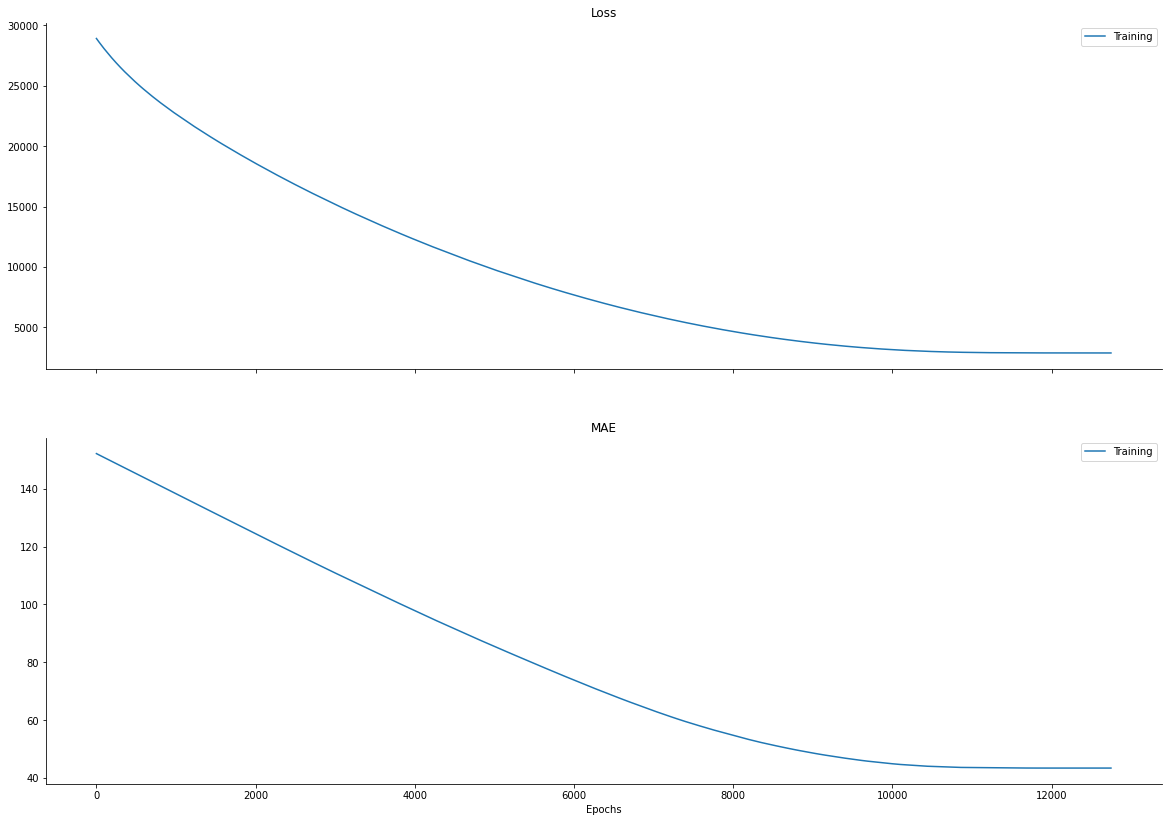

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
# ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
# ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [18]:
metrics = model.evaluate(X, y)

14/14 [==============================] - 0s 984us/step - loss: 2878.5625 - mae: 43.4087


In [19]:
import statsmodels.api as sm

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           3.83e-62
Time:                        17:48:52   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

In [32]:
from scipy import stats

lm_layer = model.get_layer(index=1)
params = np.append(lm_layer.bias.numpy(), lm_layer.weights[0].numpy())

predictions = model.predict(X)
predictions = predictions.reshape((442,))

# newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X),1)), X, axis=1)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"], myDF3["Standard Errors"], myDF3["t values"], myDF3["Probabilities"] = [params, sd_b, ts_b, p_values]
print(myDF3)

    Coefficients  Standard Errors  t values  Probabilities
0     151.610596            2.584    58.665          0.000
1      -0.314100            2.851    -0.110          0.912
2     -11.242100            2.922    -3.848          0.000
3      25.137100            3.175     7.917          0.000
4      15.309200            3.122     4.904          0.000
5      -4.685400           19.885    -0.236          0.814
6      -3.850300           16.179    -0.238          0.812
7      -9.545300           10.142    -0.941          0.347
8       4.862400            7.706     0.631          0.528
9      23.271601            8.203     2.837          0.005
10      3.338900            3.149     1.060          0.290


In [24]:
total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))

unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, predictions)))

R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error)) 

print(R_squared)

tf.Tensor(0.5145668854631638, shape=(), dtype=float64)


In [29]:
Adjusted_R_squared = 1 - (1-R_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
print(Adjusted_R_squared)

tf.Tensor(0.5033039361699657, shape=(), dtype=float64)
